# Recommending Locations for an Italian Restaurant in Fort Worth

In [1]:
# package imports
import requests
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from shapely.geometry import Point
from geopandas import GeoDataFrame
import geopandas as gpd
from scipy.spatial import cKDTree
from scipy.ndimage import label
import geopy.distance
from shapely.geometry import Point as ShapelyPoint
from shapely.geometry import Polygon

In [2]:
# API Endpoints for Fort Worth and National Data
fort_worth_url = "https://api.censusreporter.org/1.0/data/show/latest?geo_ids=16000US4827000&table_ids=B01003,B19013,B01002"
us_url = "https://api.censusreporter.org/1.0/data/show/latest?geo_ids=01000US&table_ids=B01003,B19013,B01002"

### Demographics (Census API)

In [3]:
# Fetch data
fort_worth_data = requests.get(fort_worth_url).json()
us_data = requests.get(us_url).json()

# Extract key statistics
fort_worth_geo = fort_worth_data["data"]["16000US4827000"]
us_geo = us_data["data"]["01000US"]

# Land area values (Census QuickFacts)
fort_worth_land_area = 342.2  # Fort Worth land area (sq. miles)
us_land_area = 3531905  # US total land area (sq. miles)

# Calculate population density
fort_worth_population = fort_worth_geo["B01003"]["estimate"]["B01003001"]
us_population = us_geo["B01003"]["estimate"]["B01003001"]

fort_worth_density = fort_worth_population / fort_worth_land_area
us_density = us_population / us_land_area

# Convert to DataFrame
df = pd.DataFrame({
    "Metric": ["Median Household Income", "Median Age", "Population Density (per sq. mile)"],
    "Fort Worth": [
        fort_worth_geo["B19013"]["estimate"]["B19013001"],  # Fort Worth Median Income
        fort_worth_geo["B01002"]["estimate"]["B01002001"],  # Fort Worth Median Age
        round(fort_worth_density, 2)  # Fort Worth Population Density
    ],
    "National Average": [
        us_geo["B19013"]["estimate"]["B19013001"],  # US Median Income
        us_geo["B01002"]["estimate"]["B01002001"],  # US Median Age
        round(us_density, 2)  # US Population Density
    ]
})

# Display comparison table
print(df)

# Explain the comparison
print("\n{0} is {1:.2f} times than the US medium household income.".format("Fort Worth", fort_worth_geo["B19013"]["estimate"]["B19013001"] / us_geo["B19013"]["estimate"]["B19013001"]))
print("{0} is {1:.2f} younger than the US median age.".format("Fort Worth", abs(fort_worth_geo["B01002"]["estimate"]["B01002001"] - us_geo["B01002"]["estimate"]["B01002001"])))
print("{0} is {1:.2f} times denser than the US average.".format("Fort Worth", fort_worth_density / us_density))

                              Metric  Fort Worth  National Average
0            Median Household Income    77082.00          77719.00
1                         Median Age       33.70             39.20
2  Population Density (per sq. mile)     2854.86             94.83

Fort Worth is 0.99 times than the US medium household income.
Fort Worth is 5.50 younger than the US median age.
Fort Worth is 30.11 times denser than the US average.


From the Census demographic data, we can determine the fort worth is a urban city with a younger population. 

The household income in this city is similar to the national average. 

This will be the target demographic when exploring possible locations for a resturant. 

### Income Analysis (Open Data API)

In [4]:
# Define the API URL
url = "https://data.fortworthtexas.gov/resource/ruhd-2sjc.json"

# Send a GET request to the API
response = requests.get(url)

# Check if the request was successful (status code 200)
if response.status_code == 200:
    # Load the JSON data into a list of dictionaries
    data = response.json()

    # Convert the list of dictionaries into a DataFrame
    df = pd.DataFrame(data)

else:
    print(f"Error: {response.status_code}")

# Print all coloumn names
print(df.columns)

Index(['address', 'zipcode', 'last_update_date', 'year', 'npa_name', 'lat',
       'long', 'location_1_1', 'school_district', 'population_2010',
       'median_age', 'pct_under_18', 'pct_over_65', 'pct_highschool_diploma',
       'pct_unemployed', 'total_jobs_area', 'median_household_income',
       'pct_renting', 'pct_vacant', 'pct_foreclosures', 'median_house_age',
       'sub_standard_structure_complaints', 'crimes_property', 'crimes_people',
       'uninsured_rate', 'school_subsidized_meals', 'commercial_bld_permits',
       'residential_bld_permits', 'reported_s', 'emergency_',
       'pct_poor_streets', 'sanitary_sewer_overflow_rate',
       'pct_near_grocery_store', 'pct_near_park', 'pct_near_library',
       'pct_voter_turnout'],
      dtype='object')


In [5]:
# Remove unnecessary columns
df = df.drop(columns=["pct_voter_turnout", "pct_near_library", "pct_near_park", "pct_near_grocery_store", "sanitary_sewer_overflow_rate", "pct_poor_streets", "emergency_", "reported_s", 
                      "residential_bld_permits", "commercial_bld_permits", "school_subsidized_meals", "uninsured_rate", "crimes_people", "crimes_property", "sub_standard_structure_complaints", 
                      "pct_foreclosures", "pct_vacant", "pct_renting", "total_jobs_area", "pct_unemployed", "pct_highschool_diploma"])

#Remove rows with missing values
df = df.dropna()

#Display the first 5 rows of the dataframe
df.head()

,address,zipcode,last_update_date,year,npa_name,lat,long,location_1_1,school_district,population_2010,median_age,pct_under_18,pct_over_65,median_household_income,median_house_age
0,2516 BELLATRIX DR,76052,2025-02-16 10:05:29.0933333,2017,Wise County\ ETJ,32.9939,-97.4136,"(32.9939,-97.4136)",NORTHWEST ISD,3123,30,0.3506707,0.06815366,72687,16
1,9668 ROSINA TRL,76126,2025-02-16 10:05:29.0933333,2016,Benbrook Lake\ ETJ,32.6753,-97.483,"(32.6753,-97.483)",FORT WORTH ISD,3792,47,0.21060311,0.22884241,72825,10
2,13805 MARYSRIDGE RD,76008,2025-02-16 10:05:29.0933333,2016,Walsh Ranch,32.7432,-97.5651,"(32.7432,-97.5651)",ALEDO ISD,1895,51,0.18448182,0.10743353,139353,12
3,1825 CRESTED RIDGE RD,76008,2025-02-16 10:05:29.0933333,2017,Walsh Ranch,32.7407,-97.5712,"(32.7407,-97.5712)",ALEDO ISD,1895,51,0.19410836,0.10520779,129333,21
4,1624 PURPLE THISTLE*,76008,2025-02-16 10:05:29.0933333,2016,Walsh Ranch,32.7428,-97.5781,"(32.7428,-97.5781)",ALEDO ISD,1895,51,0.18448182,0.10743353,139353,12


In [6]:
# Convert 'median_household_income' to numeric (use errors='coerce' to handle any non-numeric values)
df['median_household_income'] = pd.to_numeric(df['median_household_income'], errors='coerce')

# Remove rows where 'median_household_income' is lower than 77719
df_filtered = df[df['median_household_income'] >= 77719]

# Sort the DataFrame by 'median_household_income' in descending order
df_sorted = df_filtered.sort_values(by='median_household_income', ascending=False)

# Print the number of rows in the new DataFrame
print(f'Number of rows in the new DataFrame: {len(df_sorted)}')

Number of rows in the new DataFrame: 645


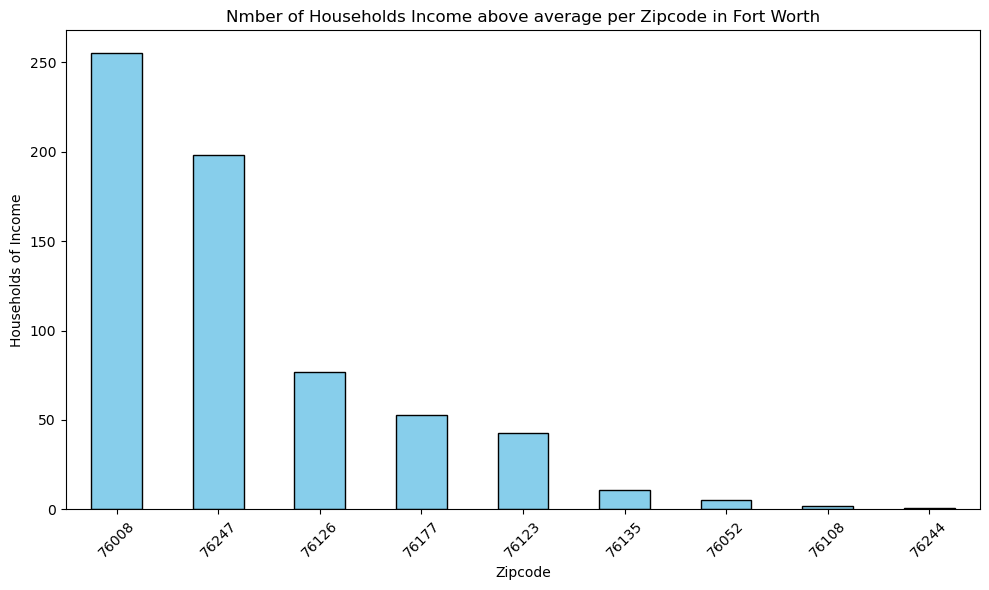

Total count of rows per zipcode:
zipcode
76008    255
76247    198
76126     77
76177     53
76123     43
76135     11
76052      5
76108      2
76244      1
Name: count, dtype: int64


In [18]:
#Visualize the distribution of median household income in Fort Worth

# Count the number of rows per zipcode
zipcode_counts = df_sorted['zipcode'].value_counts()

# Plot the counts for each zipcode
plt.figure(figsize=(10, 6))
zipcode_counts.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Nmber of Households Income above average per Zipcode in Fort Worth')
plt.xlabel('Zipcode')
plt.ylabel('Households of Income')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Print the total count for each zipcode
print("Total count of rows per zipcode:")
print(zipcode_counts)

The income data for Fort Worth shows three zipcode with the most median_household_income values above the average of fort worth which is 77719 are: 76008, 76247, 76126. These areas are the most likely to have residents with disposable income to spend at your restuarant on a more frequent bases. 

76008 is the postal code of Annetta North, TX [ 32.684116, -97.641844 ], this area is far west of fort worth. 

76247 is the postal code of Justin, TX [33.035355, -97.289512], this area is far north of fort worth.

76126 is west

76177 is north

76123 is west

76135 (Lakeside) north west

### Crime & Safety Metrics (Open Data API)

In [7]:
# API endpoint URL
url = "https://data.fortworthtexas.gov/resource/k6ic-7kp7.json"

# Send a GET request to the API endpoint
response = requests.get(url)

# Check if the request was successful (status code 200)
if response.status_code == 200:
    # Convert the JSON data into a pandas DataFrame
    df = pd.DataFrame(response.json())
else:
    print(f"Failed to fetch data. Status code: {response.status_code}")

In [8]:
# Clean the data
#Remove unnecessary columns
df = df.drop(['case_no_offense', 'state', 'location_1', ':@computed_region_nnh8_mcwc', ':@computed_region_yjg4_vj9w', 
              ':@computed_region_bgtw_5uv7', ':@computed_region_fn9q_qpdm', ':@computed_region_qwjb_2inx', 'offense_desc', 'offense', 'beat', 'attempt_complete', 'from_date'], axis=1)

# Drop rows with missing values
df = df.dropna()

# Display the first few rows of the cleaned DataFrame
df.head()

,case_no,reported_date,nature_of_call,block_address,city,location_type,locationtypedescription,division,councildistrict
1,200085517,2020-11-03T13:24:00.000,HARASS,1300 MARLBOROUGH DR,FORT WORTH,20,20 RESIDENCE/HOME,South,8
2,210012743,2021-02-20T20:27:59.000,AUTO THEFT,SANDY LN & EDERVILLE RD,FORT WORTH,18,18 PARKING LOT/GARAGE,East,5
5,210038831,2021-05-22T01:21:23.000,ASSAULT,6000 STONEYBROOK DR,FORT WORTH,15,15 JAIL/PRISON,East,4
7,190028164,2019-04-03T12:05:08.000,CRIMINAL MISCHIEF,SOUTH FWY,FORT WORTH,13,13 HIGHWAY/ROAD/ALLEY,Central,9
9,190055743,2019-06-28T19:50:02.000,ARSON,4900 E BERRY ST,FORT WORTH,20,20 RESIDENCE/HOME,East,5


/var/folders/1x/d63v0p1x0t7cpz8_8l_1n7rm0000gn/T/ipykernel_40736/1687022308.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=nature_of_call_counts.values, y=nature_of_call_counts.index, palette='viridis')


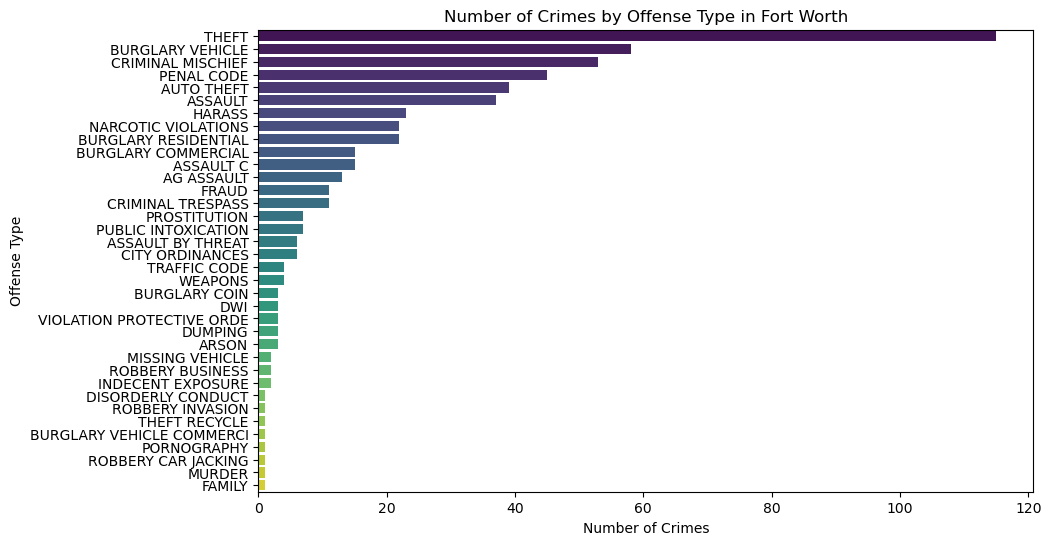

/var/folders/1x/d63v0p1x0t7cpz8_8l_1n7rm0000gn/T/ipykernel_40736/1687022308.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=division_counts.values, y=division_counts.index, palette='viridis')


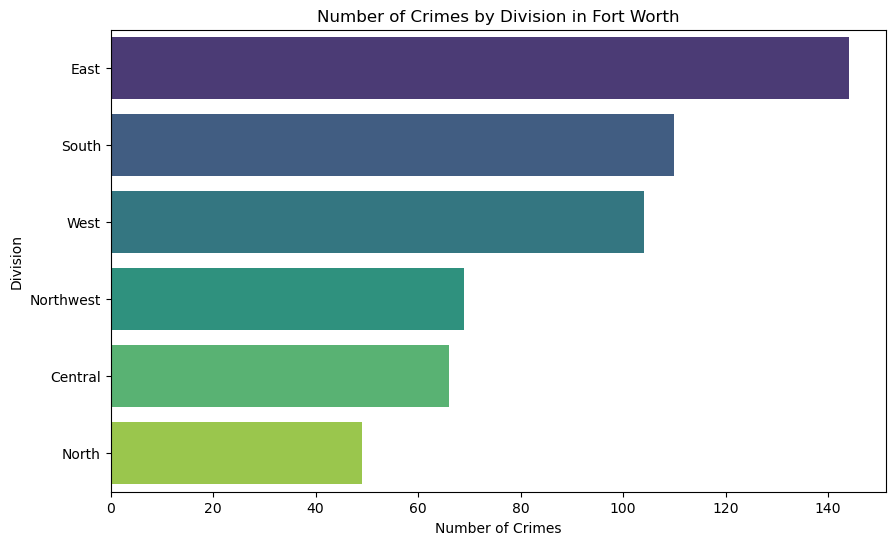

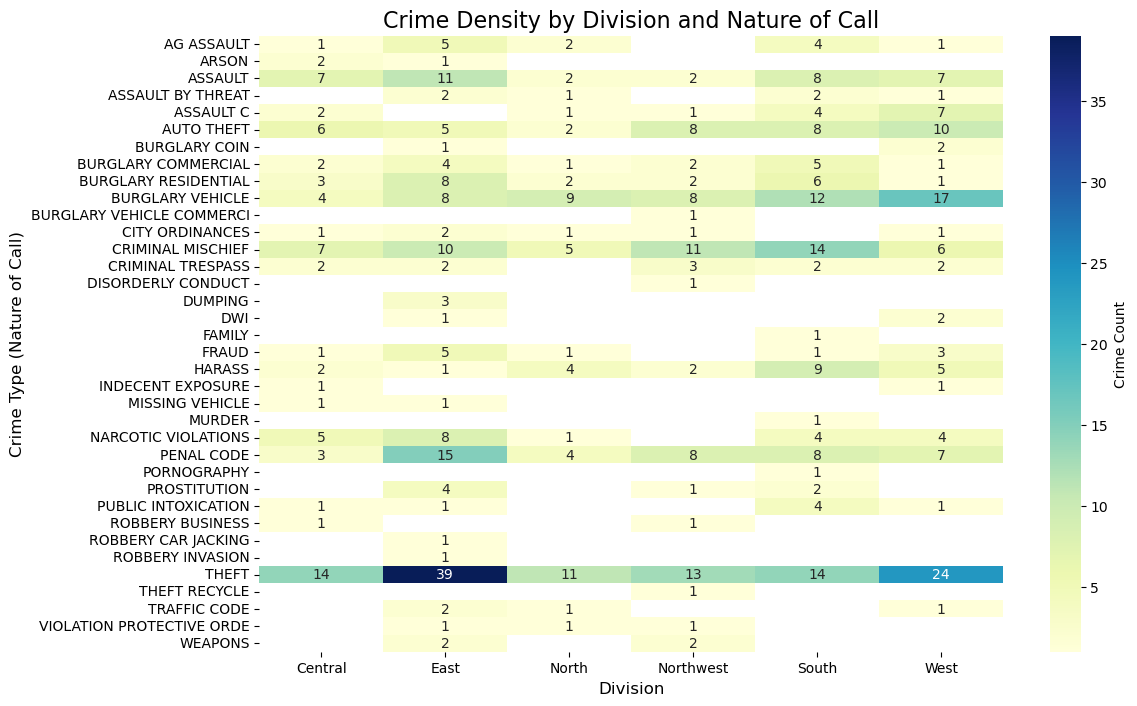

In [9]:
# 1. Bar chart: Number of Crimes by Offense Type (nature_of_call)
nature_of_call_counts = df['nature_of_call'].value_counts()

plt.figure(figsize=(10, 6))
sns.barplot(x=nature_of_call_counts.values, y=nature_of_call_counts.index, palette='viridis')
plt.xlabel('Number of Crimes')
plt.ylabel('Offense Type')
plt.title('Number of Crimes by Offense Type in Fort Worth')
plt.show()

# 2. Bar chart: Number of Crimes by Division
division_counts = df['division'].value_counts()

plt.figure(figsize=(10, 6))
sns.barplot(x=division_counts.values, y=division_counts.index, palette='viridis')
plt.xlabel('Number of Crimes')
plt.ylabel('Division')
plt.title('Number of Crimes by Division in Fort Worth')
plt.show()

# 3. Heatmap: Crime Density by Division and Nature of Call

# Count the number of occurrences for each combination of division and nature_of_call
crime_density = df.groupby(['division', 'nature_of_call']).size().reset_index(name='Count')

# Create a pivot table to summarize the number of occurrences by division and crime type
pivot = crime_density.pivot(index='nature_of_call', columns='division', values='Count')

# Create the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(pivot, annot=True, cmap='YlGnBu', cbar_kws={'label': 'Crime Count'})

# Set the title and labels
plt.title('Crime Density by Division and Nature of Call', fontsize=16)
plt.xlabel('Division', fontsize=12)
plt.ylabel('Crime Type (Nature of Call)', fontsize=12)

# Show the heatmap
plt.show()


From the crime data for Fort Worth we can see that the three divison with the lowest crime density is north, central, and nortwest. 

Since the worst crime is the East and South, the crimes seems to trends downward the further north and west in Fort Worth. 

According to NeighbhorhoodScout, the 10 Safest Fort Worth Area Neighborhoods in order: 

Lake of River Trails (East)

Haslet South (North)

Montserrat (West)

Avondale (North)

Pecan Acres (North)

Mira Vista (South)

Lakeside (West)

Villages of Woodland Springs East (North)

Pearson Ranch Rd / White Settlement Rd (West)

Heritage Northeast (North)

Due to this, the safest location to open would be in the north or west division of Fort Worth.

### Competitive Analysis (Yelp API)

In [10]:
# Define the Yelp API URL
url = "https://api.yelp.com/v3/businesses/search"

# Yelp API key
YELP_API_KEY = "zkSIFH90yceqWskaNK4m3RXf4n6SUQYChOc0in3xLXC089-3LEBMBSpI8LVALGtdOhevxhHFWJaO0wun9DEpdNFsvv5cotUS_PDxp_cETEWKeU95YXYK8EHKq4yyZ3Yx"

# Set headers with API Key (Make sure to replace 'YELP_API_KEY' with your actual API key)
headers = {"Authorization": f"Bearer {YELP_API_KEY}"}

In [11]:
#Data for Italian Restaurants in Fort Worth
# Initialize an empty list to store the results
restaurant_list = []
offset = 0
limit = 50  # Max allowed per request
max_offset = 190  # Yelp restricts offset+limit to 240, so max_offset is 240 - 50 = 190

# Fetch data in batches
while offset <= max_offset:
    # Parameters for Yelp API search
    params = {
        "term": "Italian Restaurant",
        "location": "Fort Worth, TX",
        "categories": "italian",
        "limit": limit,  # Yelp max per request
        "offset": offset  # Pagination control
    }

    # Make API request
    response = requests.get(url, headers=headers, params=params)
    data = response.json()

    # Check if valid data is returned
    if "businesses" in data:
        businesses = data["businesses"]
        if not businesses:
            break  # No more results available

        # Extract relevant information from businesses and append to the list
        for business in businesses:
            # Ensure that the rating is valid (could be missing or malformed)
            rating = business.get("rating", None)
            if rating is not None:  # Only append if rating is available
                restaurant_list.append({
                    "Name": business["name"],
                    "Rating": rating,
                    "Reviews": business["review_count"],
                    "Price": business.get("price", "N/A"),
                    "Latitude": business["coordinates"]["latitude"],
                    "Longitude": business["coordinates"]["longitude"],
                    "Address": ", ".join(business["location"]["display_address"])
                })

        offset += limit  # Move to the next batch
    else:
        print("Error fetching data:", data)
        break  # Stop execution if an error occurs

# Convert results to Pandas DataFrame
df = pd.DataFrame(restaurant_list)

# Sort by Rating (Highest First)
df = df.sort_values(by="Rating", ascending=False)

# You can now use the `df` DataFrame to further process or display the results.
print(df.head())

# Total number of Italian restaurants
total_restaurants = len(df)

# Average rating of Italian restaurants
average_rating = df["Rating"].mean()

# Display summary statistics
print(f"\nTotal Italian Restaurants in Fort Worth: {total_restaurants}")
print(f"Average Rating of Italian Restaurants: {average_rating:.2f}")

                            Name  Rating  Reviews Price   Latitude  Longitude  \
33                     Govanni's     5.0        1   N/A  32.662556 -97.347908   
85         Fuhgeddaboudit Breads     5.0        1   N/A  32.922375 -97.233887   
108  mamma's pasta house & pizza     5.0        1   N/A  32.824933 -97.060751   
127           El guero’s kitchen     5.0        3   N/A  32.821055 -97.264201   
157  Villa Fresh Italian Kitchen     5.0        1   N/A  32.678340 -97.398430   

                                             Address  
33             5733 Crowley Rd, Fort Worth, TX 76134  
85                                  Keller, TX 76248  
108    4212 Hwy 360, Ste 200 B, Fort Worth, TX 76155  
127           4000 Denton Hwy, Haltom City, TX 76117  
157  4800 S Hulen St, Ste 2100, Fort Worth, TX 76132  

Total Italian Restaurants in Fort Worth: 200
Average Rating of Italian Restaurants: 3.92


In [12]:
# Define Fort Worth's boundaries for grid generation
latitude_bounds = [32.7, 33.0]
longitude_bounds = [-97.5, -97.3]

# Create a grid of cells using numpy
cell_size = 0.01  # Size of each grid cell, adjust as needed
latitudes = np.arange(latitude_bounds[0], latitude_bounds[1], cell_size)
longitudes = np.arange(longitude_bounds[0], longitude_bounds[1], cell_size)

# Create grid points (latitude, longitude pairs)
grid_points = [(lat, lon) for lat in latitudes for lon in longitudes]

# Create a GeoDataFrame with grid cells
geometry = [Point(lon, lat) for lat, lon in grid_points]
grid_gdf = GeoDataFrame(geometry=geometry)

# Create a GeoDataFrame for the restaurants using df
restaurant_points = [Point(lon, lat) for lon, lat in zip(df['Longitude'], df['Latitude'])]
restaurants_gdf = GeoDataFrame(geometry=restaurant_points)

# Perform spatial join to count restaurant ratings in each grid cell
# Assuming the rating column is 'Rating' in the dataframe df
grid_gdf['restaurant_count'] = grid_gdf.apply(lambda row: sum(row.geometry.contains(pt) for pt in restaurants_gdf.geometry), axis=1)
grid_gdf['rating_sum'] = grid_gdf.apply(lambda row: sum(df['Rating'][df['Longitude'].isin([pt.x for pt in restaurants_gdf.geometry]) & df['Latitude'].isin([pt.y for pt in restaurants_gdf.geometry])]), axis=1)

# Compute density of ratings (rating sum per grid cell)
grid_gdf['rating_density'] = grid_gdf['rating_sum'] / grid_gdf['restaurant_count']

# Sort the grid cells by rating density in descending order to find highest density regions
grid_gdf_sorted = grid_gdf.sort_values(by='rating_density', ascending=False)

# Get the coordinates of the two regions with the highest rating density
top_2_regions = grid_gdf_sorted.head(2)
top_2_coords = top_2_regions[['geometry']].apply(lambda x: (x.geometry.y, x.geometry.x), axis=1).tolist()

print("Coordinates of the two regions with the highest rating density:")
for i, coords in enumerate(top_2_coords, 1):
    print(f"Region {i}: Latitude {coords[0]}, Longitude {coords[1]}")

Coordinates of the two regions with the highest rating density:
Region 1: Latitude 32.7, Longitude -97.5
Region 2: Latitude 32.89999999999996, Longitude -97.46999999999998


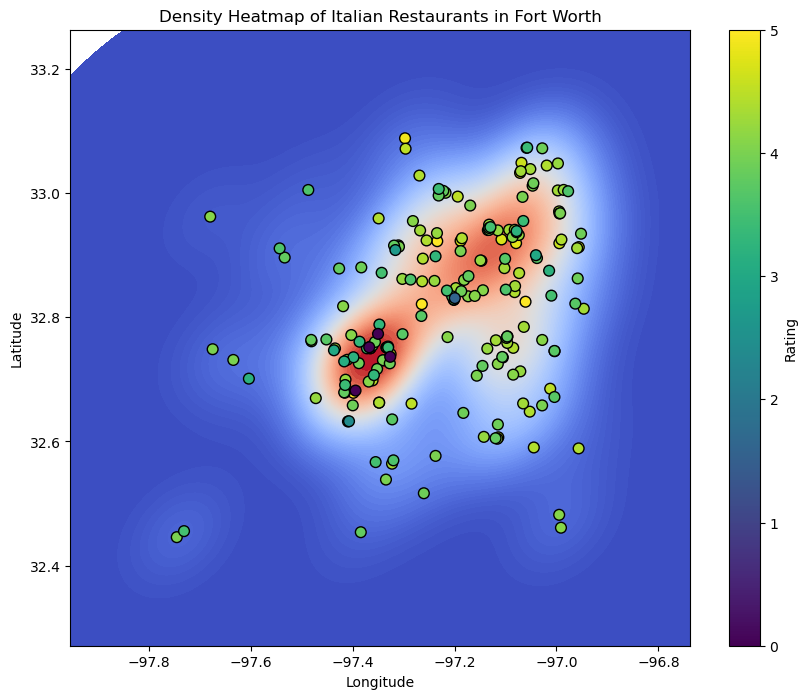

In [13]:
# Plotting the Density Heatmap of Italian Restaurants in Fort Worth based on their Ratings

plt.figure(figsize=(10, 8))
sns.kdeplot(x=df['Longitude'], y=df['Latitude'], cmap="coolwarm", fill=True, thresh=0, levels=100)
plt.scatter(df['Longitude'], df['Latitude'], c=df['Rating'], cmap="viridis", edgecolor='k', s=60)
plt.colorbar(label='Rating')
plt.title('Density Heatmap of Italian Restaurants in Fort Worth')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

In [14]:
# Find the region with the lowest density of Italian restaurants
# Latitude and longitude bounds
latitude_bounds = [32.7, 33.0]
longitude_bounds = [-97.5, -97.3]

# Filter the DataFrame based on the given bounds
filtered_df = df[
    (df["Latitude"] >= latitude_bounds[0]) & (df["Latitude"] <= latitude_bounds[1]) &
    (df["Longitude"] >= longitude_bounds[0]) & (df["Longitude"] <= longitude_bounds[1])
]

# Check if there are any restaurants within the bounds
if not filtered_df.empty:
    # Sort by Latitude and Longitude to analyze spatial distribution
    filtered_df = filtered_df.sort_values(by=["Latitude", "Longitude"])

    # Function to calculate the distance between two coordinates
    def calculate_distance(coord1, coord2):
        return geopy.distance.geodesic(coord1, coord2).meters

    # List of restaurant coordinates within the bounds
    coordinates = filtered_df[["Latitude", "Longitude"]].values

    # Find the largest gaps by comparing distances between consecutive restaurants
    largest_gap = 0
    largest_gap_coords = None

    for i in range(1, len(coordinates)):
        dist = calculate_distance(coordinates[i-1], coordinates[i])
        if dist > largest_gap:
            largest_gap = dist
            largest_gap_coords = (coordinates[i-1], coordinates[i])

    print(f"Largest gap between restaurants: {largest_gap} meters")
    print(f"Coordinates of gap: {largest_gap_coords}")
else:
    print("No restaurants found within the given bounds.")

Largest gap between restaurants: 11916.410856872695 meters
Coordinates of gap: (array([ 32.817669, -97.418523]), array([ 32.861602, -97.302366]))


<Figure size 1000x800 with 0 Axes>

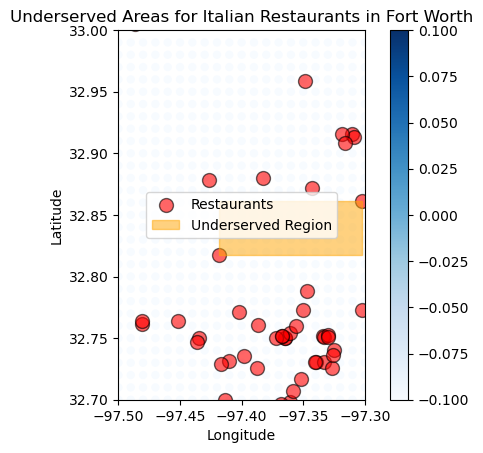

In [15]:
# Coordinates of the largest gap between restaurants
largest_gap_coords = (
    np.array([32.817669, -97.418523]),  # Point 1: Latitude, Longitude
    np.array([32.861602, -97.302366])   # Point 2: Latitude, Longitude
)

# Define Fort Worth's boundaries for grid generation
latitude_bounds = [32.7, 33.0]
longitude_bounds = [-97.5, -97.3]

# Create a grid of cells using numpy
cell_size = 0.01  # Size of each grid cell, adjust as needed
latitudes = np.arange(latitude_bounds[0], latitude_bounds[1], cell_size)
longitudes = np.arange(longitude_bounds[0], longitude_bounds[1], cell_size)

# Create grid points (latitude, longitude pairs)
grid_points = [(lat, lon) for lat in latitudes for lon in longitudes]

# Create a GeoDataFrame with grid cells
geometry = [Point(lon, lat) for lat, lon in grid_points]
grid_gdf = GeoDataFrame(geometry=geometry)

# Create a GeoDataFrame for the restaurants using df
restaurant_points = [Point(lon, lat) for lon, lat in zip(df['Longitude'], df['Latitude'])]
restaurants_gdf = GeoDataFrame(geometry=restaurant_points)

# Perform spatial join to count restaurants in each grid cell
grid_gdf['restaurant_count'] = grid_gdf.apply(lambda row: sum(row.geometry.contains(pt) for pt in restaurants_gdf.geometry), axis=1)

# Visualizing the Grid and Underserved Locations
plt.figure(figsize=(10, 8))

# Plot grid cells with restaurant density, but remove the grid lines
grid_gdf.plot(column='restaurant_count', cmap='Blues', linewidth=0.8, edgecolor='none', legend=True)

# Add restaurant points on top of the grid
plt.scatter(df['Longitude'], df['Latitude'], c='red', edgecolors='k', alpha=0.6, s=100, label='Restaurants')

# If the largest gap exists, highlight the region of the largest gap
if largest_gap_coords:
    # Calculate midpoint of the largest gap
    mid_lat = (largest_gap_coords[0][0] + largest_gap_coords[1][0]) / 2
    mid_lon = (largest_gap_coords[0][1] + largest_gap_coords[1][1]) / 2
    
    # Create a rectangular highlight around the two coordinates (gap region)
    highlight_polygon = Polygon([
        (largest_gap_coords[0][1], largest_gap_coords[0][0]),  # Bottom left
        (largest_gap_coords[0][1], largest_gap_coords[1][0]),  # Top left
        (largest_gap_coords[1][1], largest_gap_coords[1][0]),  # Top right
        (largest_gap_coords[1][1], largest_gap_coords[0][0])   # Bottom right
    ])
    
    # Plot the rectangle (highlighted area)
    x, y = highlight_polygon.exterior.xy
    plt.fill(x, y, color='orange', alpha=0.5, label='Underserved Region')

# Set plot boundaries to the Fort Worth latitude and longitude
plt.xlim(longitude_bounds[0], longitude_bounds[1])
plt.ylim(latitude_bounds[0], latitude_bounds[1])

# Adding title and labels
plt.title('Underserved Areas for Italian Restaurants in Fort Worth')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

plt.legend()
plt.show()


From this box we can set the region [ 32.817669, -97.418523 ], [ 32.861602, -97.302366 ], which is a northwest region is the largest area without an italian resturant. 

The two region with the highest density of highly rating italian resturants are centered around[ 32.7, -97.5 ] and [ 32.89999999999996, -97.46999999999998 ]. 

These region are much further northwest from the center of Fort Worth. 

Bringing a quality italian restuarant closer to central but within that region would make sense as their is already a customer based in the northwest of Fort Worth. 